# Imports

In [1]:
import torch
import pickle
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

from skimage import transform
from torch.utils.data import DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))
sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
torch.__version__

'1.0.1.post2'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
from dataset import *
from show import *
from utils import *
from constants import *

# Loading Dataset Patches

In [6]:
path = to_file_path('images', 'hdf5')
n_rows = pickle.load(open(to_file_path('n_rows', 'p'), 'rb'))
n_crops = pickle.load(open(to_file_path('crops', 'p'), 'rb'))

In [7]:
dset = FacadesDatasetH5Patches(path)
len(dset)

4776

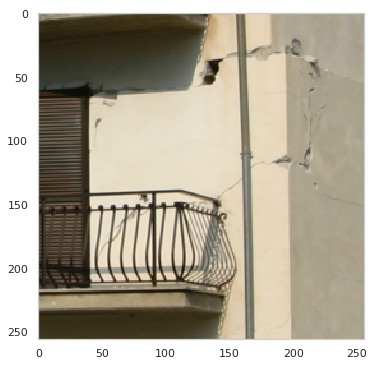

In [8]:
show_img(dset[6]['image'])

In [9]:
dset_full = FacadesDatasetH5Full(path, n_rows, n_crops)
len(dset_full)

418

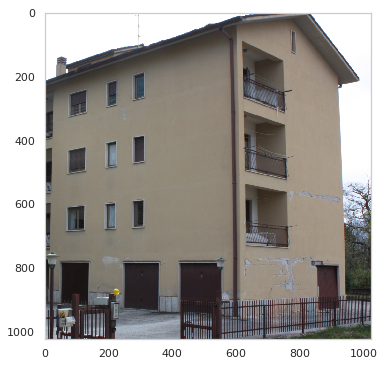

In [115]:
show_img(dset_full[416]['image'])

In [11]:
idx = 6
sample = dset[idx]
img, lbl = sample['image'], sample['label']
label_names = dset.labels

print(img.shape, img.dtype)
print(lbl.shape, lbl.dtype)
print(label_names)

torch.Size([3, 256, 256]) torch.float32
torch.Size([1, 256, 256]) torch.int64
{'door': 1, 'window': 4, '_background_': 0, 'wall': 3, 'object': 2}


# Displaying data

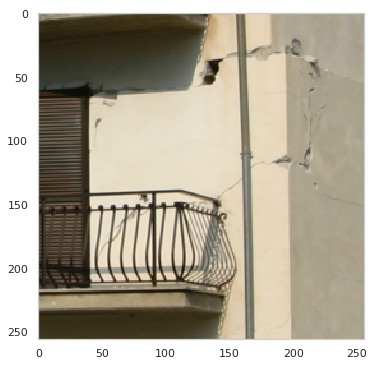

In [12]:
show_img(img)

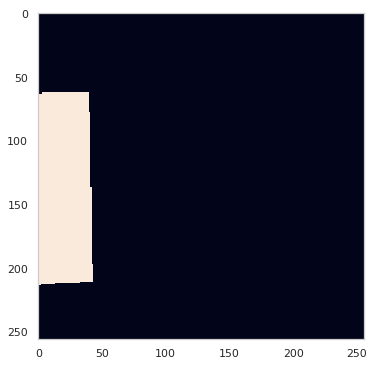

In [13]:
show_img(lbl)

(256, 256, 3) (256, 256, 1)


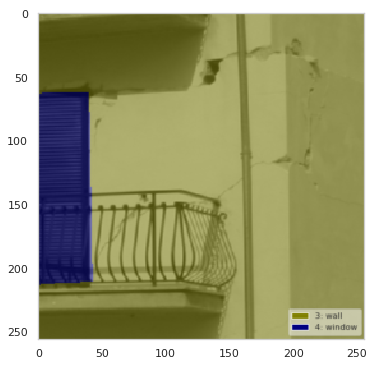

In [14]:
show_labeled_img(img, lbl, label_names)

# Filtering when not enough labels and/or not balanced

In [15]:
from filtering import subset

In [20]:
file_path = '{}/dataset_proportion{}.p'.format(path_to_data, cropped_str)
subdset = subset(
    dset,
    file_path,
    min_num_lbl=2,
    min_prop_lbl=0.2,
)

len(dset), len(subdset)

(4776, 2514)

# Data Augmentation

In [23]:
import torchvision.transforms as T

In [42]:
img = dset_full[0]['image']

## Crop & Resize

We could also do and random crop (scale of the crop is random also) and then we resize!

In [47]:
def random_crop_and_resize(img, crop_size, resize_size, is_label=False):
    itp = 0 if is_label else 2 #0 is nearest, 2 is bilinear interpolation
    return T.Compose([
        T.ToPILImage(),
        T.RandomCrop(crop_size),
        T.Resize(resize_size, interpolation=itp),
        T.ToTensor(),
    ])(img)

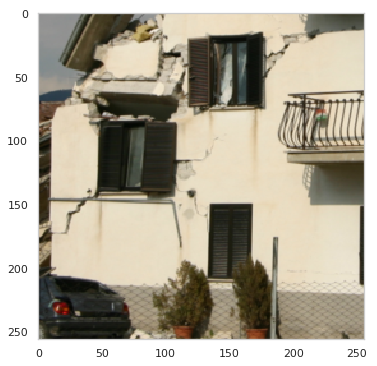

In [114]:
show_img(random_crop_and_resize(img, (400, 400), (256, 256)))

## Rotation (max 20°)

In [98]:
def random_rot(img, max_deg, crop_size, is_label=False):
    itp = 0 if is_label else 2 #0 is nearest, 2 is bilinear interpolation
    return T.Compose([
        T.ToPILImage(),
        T.RandomRotation(max_deg, resample=itp),
        T.CenterCrop(min(img.shape[1:]) * 0.8), # TODO COMPUTE THIS AUTOMATICALLY
        T.RandomCrop(crop_size),
        T.ToTensor(),
    ])(img)

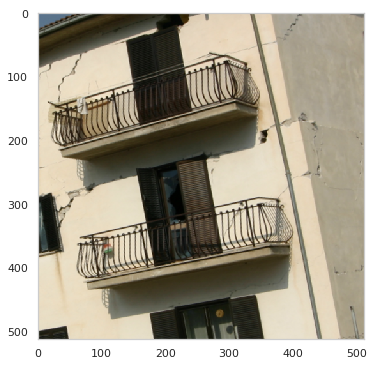

In [102]:
show_img(random_rot(img, 10, (512, 512)))

## Horizontal flip

In [108]:
def random_flip(img, p=0.5):
    return T.Compose([
        T.ToPILImage(),
        T.RandomHorizontalFlip(p),
        T.ToTensor(),
    ])(img)

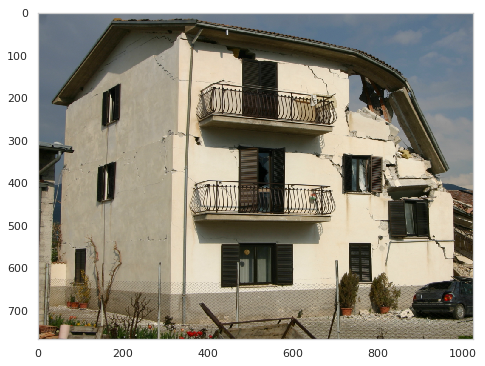

In [111]:
show_img(random_flip(img))

# Going further - DataLoader

In [30]:
dataloader = DataLoader(subdset, batch_size=4, shuffle=True, num_workers=0)

(260, 1034, 3) (260, 1034)


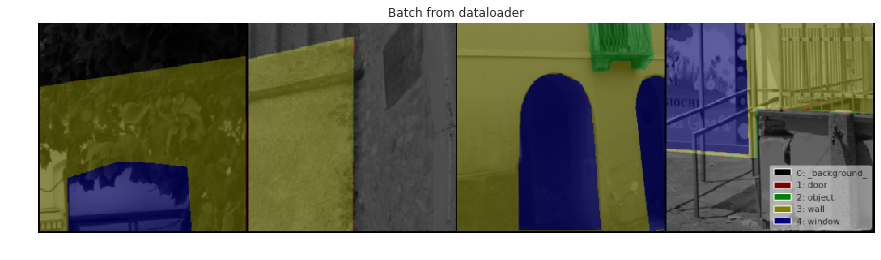

In [31]:
for i_batch, sample_batched in enumerate(dataloader):
    #print(i_batch, sample_batched['image'].size(), sample_batched['label'].size())

    # just testing, we don't iterate over the whole thing...
    if i_batch == 4:
        plt.figure()
        show_batch(sample_batched, label_names, 4)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break